In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate

import joblib

In [2]:
df=pd.read_csv("feature_enginered_products.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   store             3400 non-null   object 
 1   category          3400 non-null   object 
 2   name              3400 non-null   object 
 3   product-link      3400 non-null   object 
 4   image_url         3400 non-null   object 
 5   cleaned_category  3400 non-null   object 
 6   cleaned_name      3400 non-null   object 
 7   cleaned_quantity  3400 non-null   float64
 8   cleaned_unit      3400 non-null   object 
 9   cleaned_price     3400 non-null   float64
dtypes: float64(2), object(8)
memory usage: 265.8+ KB
None


In [3]:
df["price_per_unit"]=df["cleaned_price"]/df["cleaned_quantity"]

In [4]:
predicted_df=pd.DataFrame(data=[],columns=list(df.columns)+["predicted_cleaned_price"])
predicted_df.to_csv("predicted_prices.csv",index=False)

Category: Baby Food, Number of items: 204
Modelling for  {'Baby Food'}


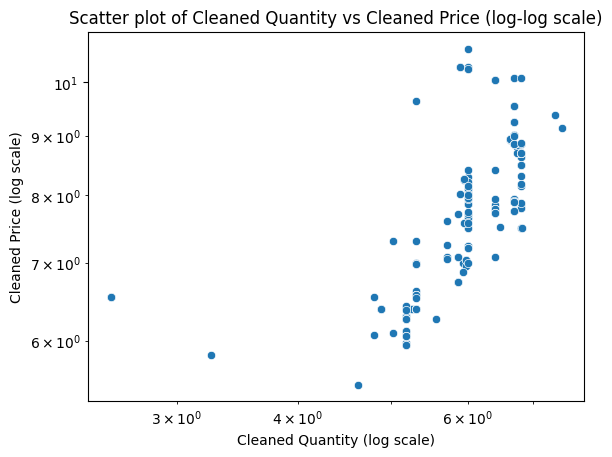

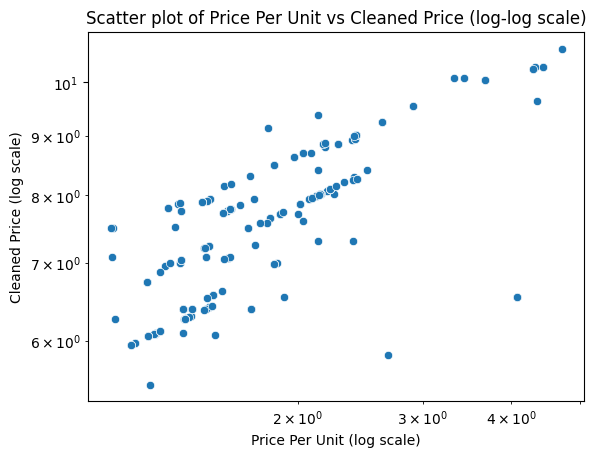

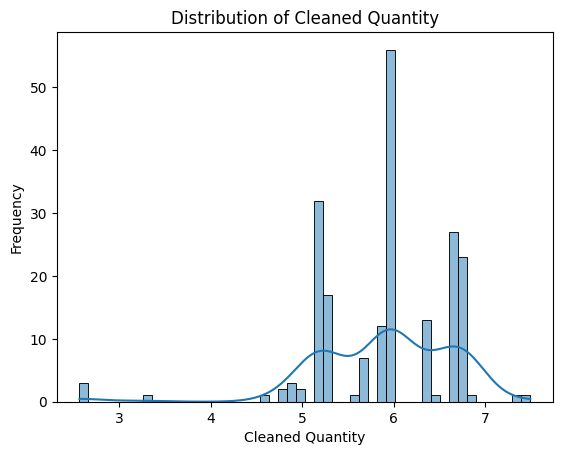

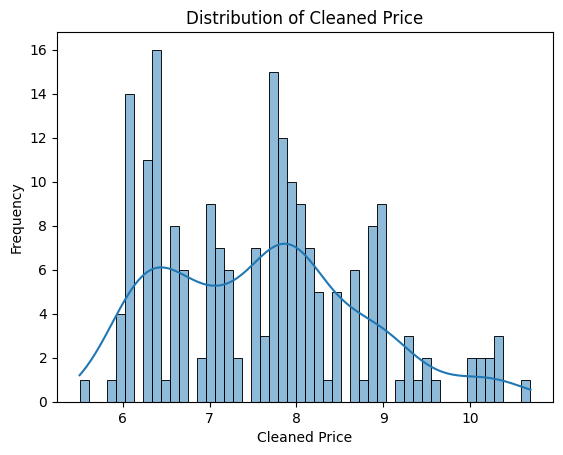

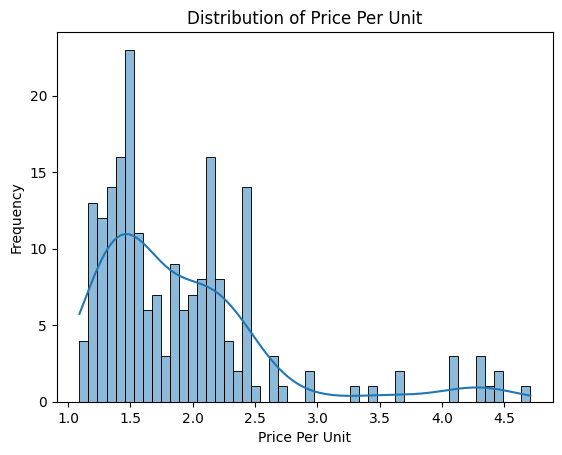

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.1}
Best CV Score (MSE): 0.0019782585613122815
Cross-Validation Results:
-0.0021179673480209524 0.9983969103379207
Training Results:
-0.0017369742474155397 0.9986925796405753
Test Results
 0.0013857619466409806 0.9985961277863596
############################################################################################################################################################################################################################################################################################################
Category: Beverages, Number of items: 1234
Modelling for  {'Beverages'}


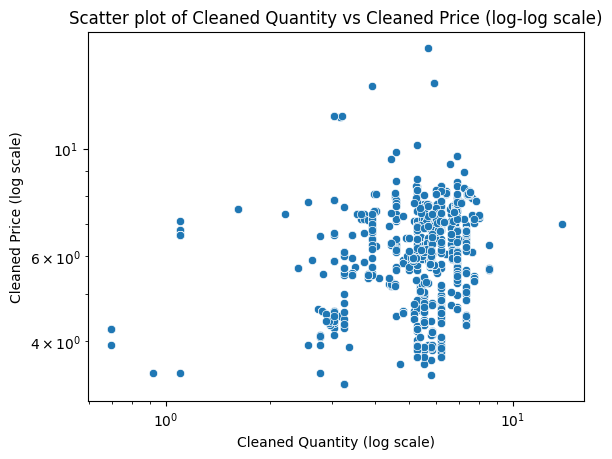

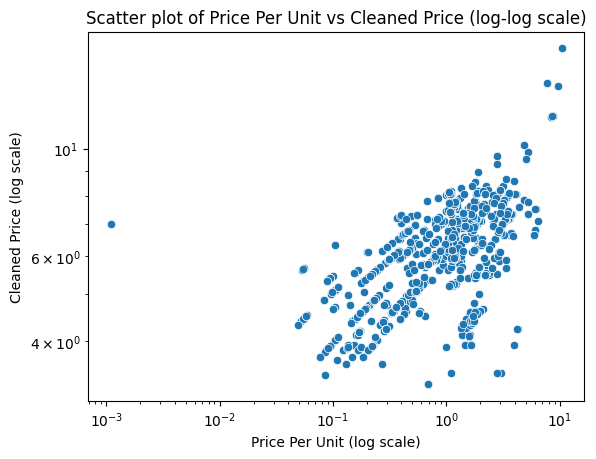

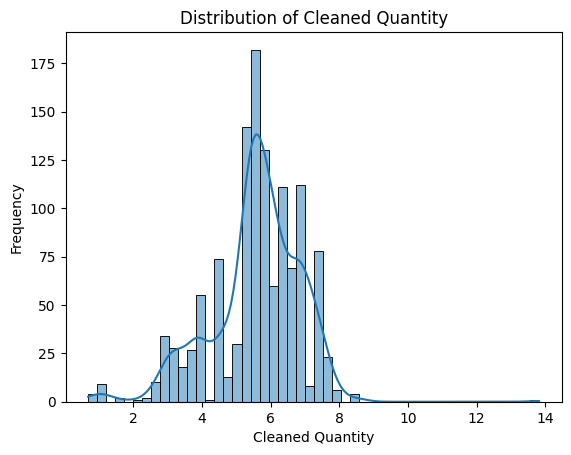

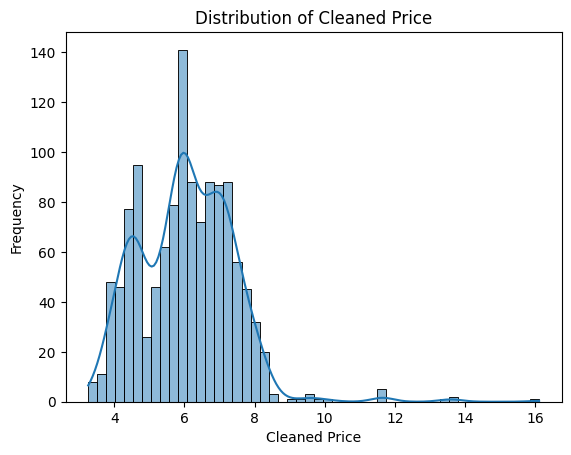

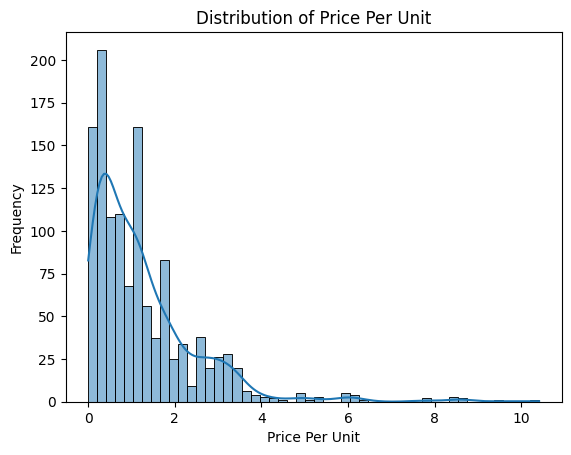

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.1}
Best CV Score (MSE): 0.2159267180009709
Cross-Validation Results:
-0.2243130645097788 0.8740139790334963
Training Results:
-0.19081436428602377 0.8927088031596176
Test Results
 0.15975505353596758 0.9185748984443574
############################################################################################################################################################################################################################################################################################################
Category: Dairy, Number of items: 733
Modelling for  {'Dairy'}


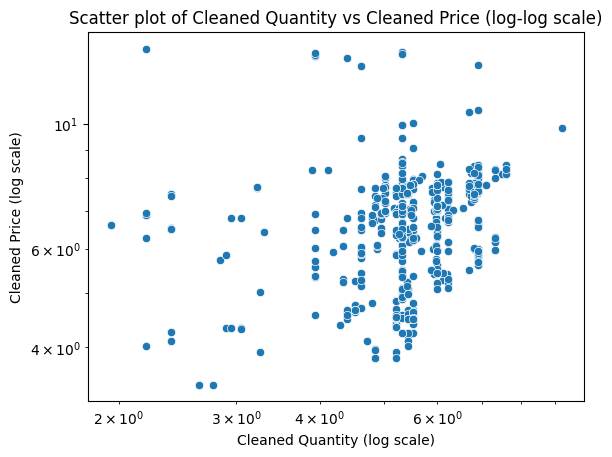

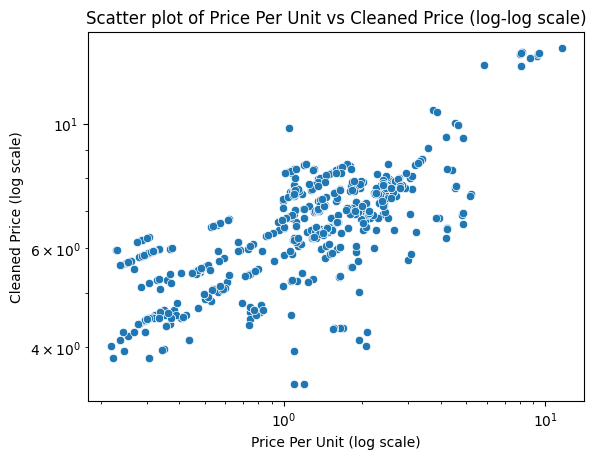

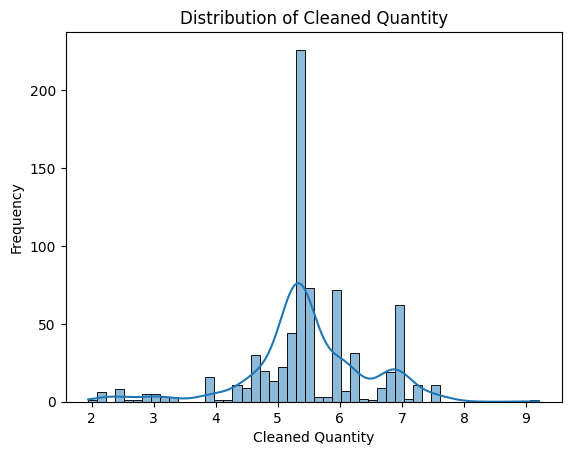

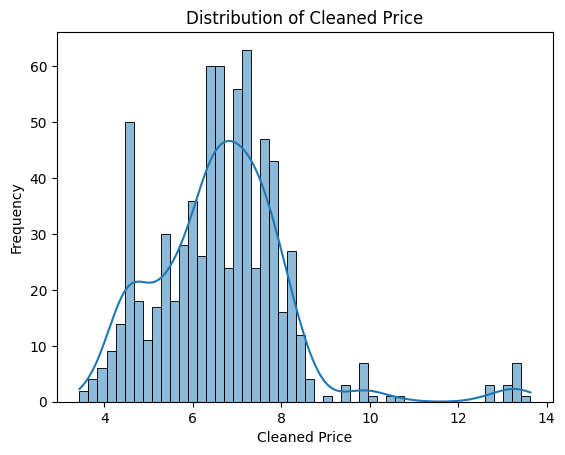

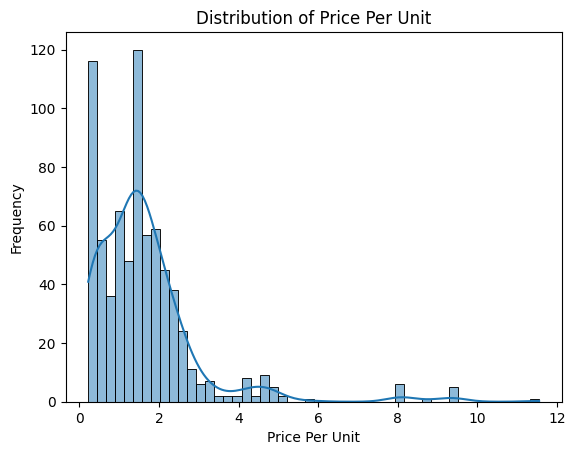

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.1}
Best CV Score (MSE): 0.07077835183799461
Cross-Validation Results:
-0.07890353890353832 0.964070937091964
Training Results:
-0.06200865393292587 0.9717908750374127
Test Results
 0.07482917986473042 0.974896099805457
############################################################################################################################################################################################################################################################################################################
Category: Snacks, Number of items: 639
Modelling for  {'Snacks'}


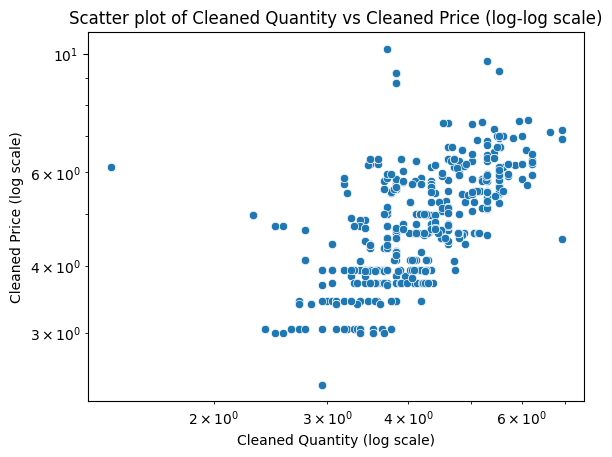

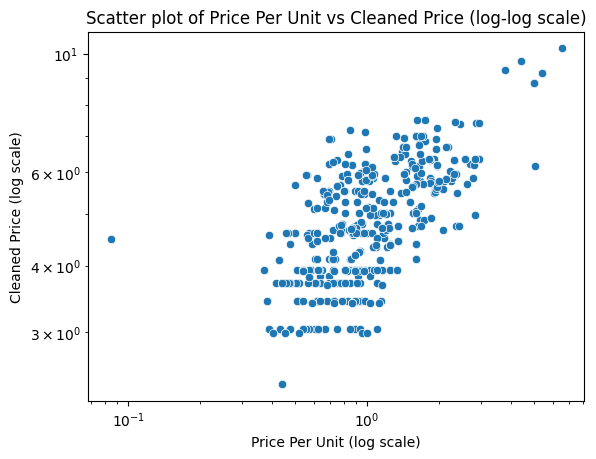

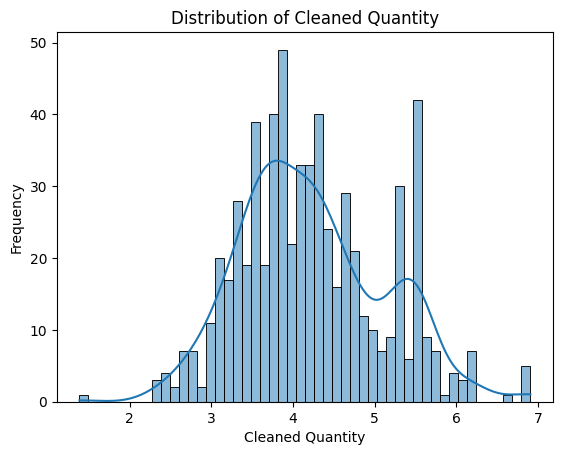

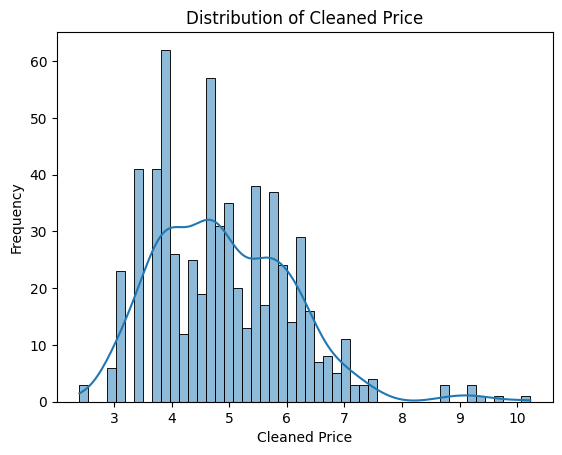

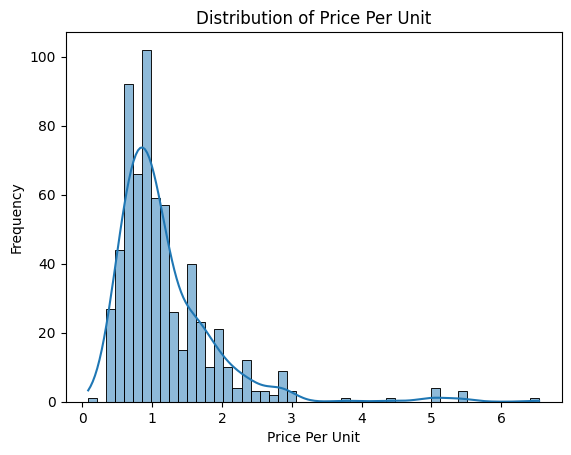

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.1}
Best CV Score (MSE): 0.02844179218945043
Cross-Validation Results:
-0.027994451783473685 0.9795116590053257
Training Results:
-0.020622985539515894 0.985146318172581
Test Results
 0.019180959813507967 0.9866971671556635
############################################################################################################################################################################################################################################################################################################
Category: Spices & Seasonings, Number of items: 264
Modelling for  {'Spices & Seasonings'}


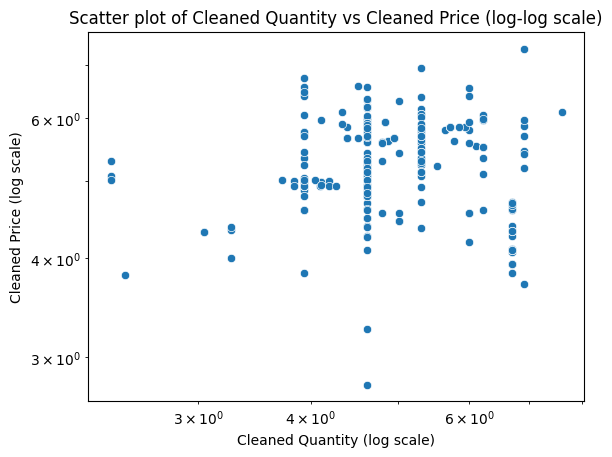

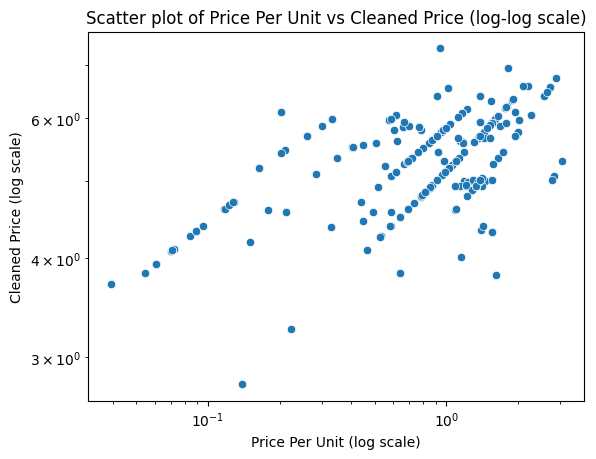

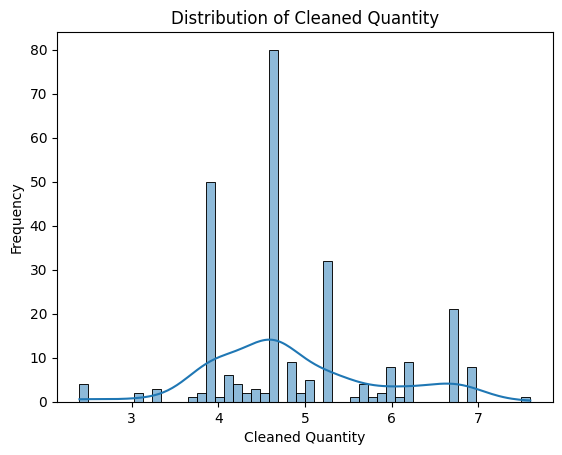

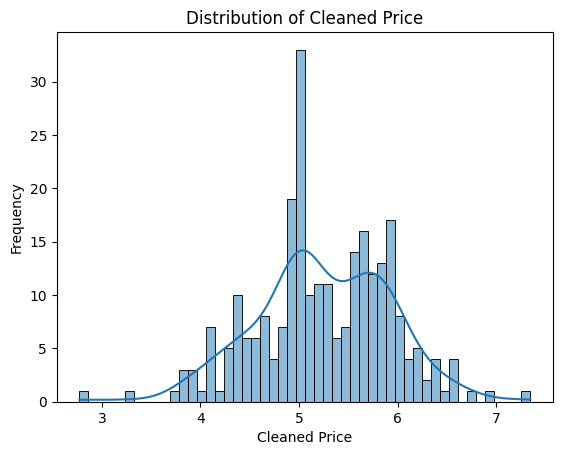

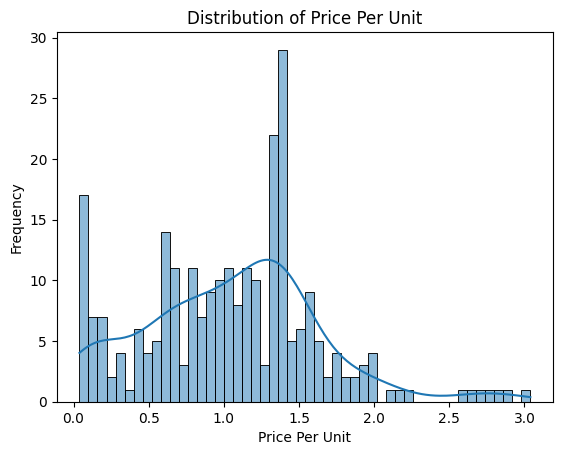

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}
Best CV Score (MSE): 0.14387121837689043
Cross-Validation Results:
-0.13409279279578007 0.7070493554870039
Training Results:
-0.12813550342034438 0.7187789712654874
Test Results
 0.10247718390464734 0.7884460788343777
############################################################################################################################################################################################################################################################################################################
Category: Staples, Number of items: 326
Modelling for  {'Staples'}


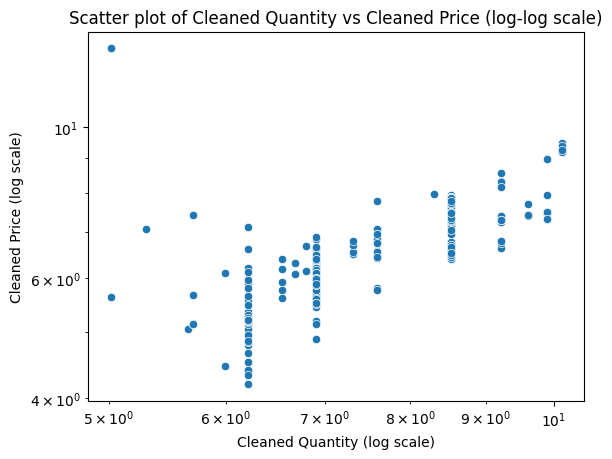

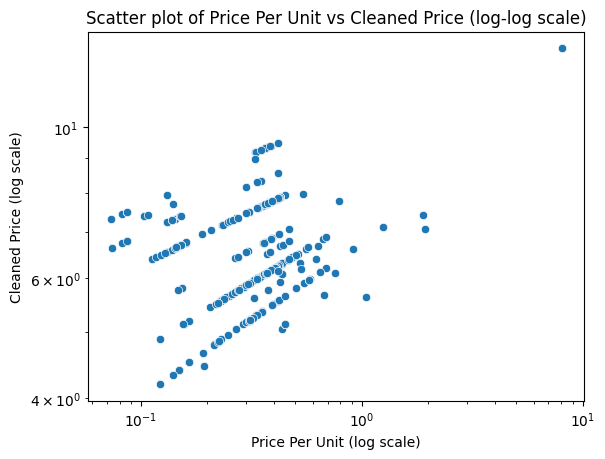

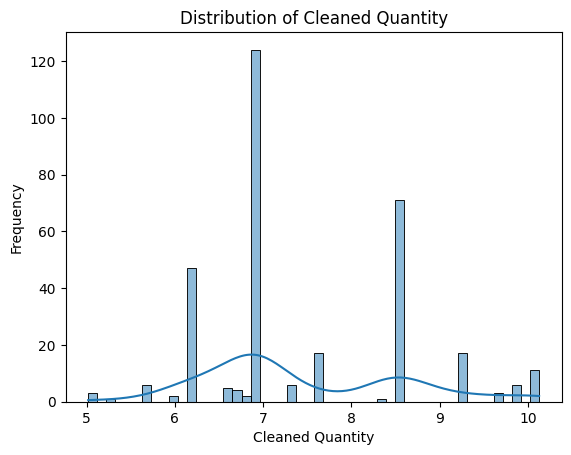

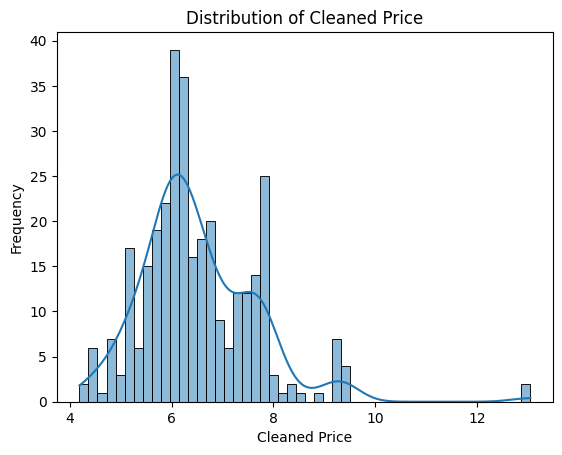

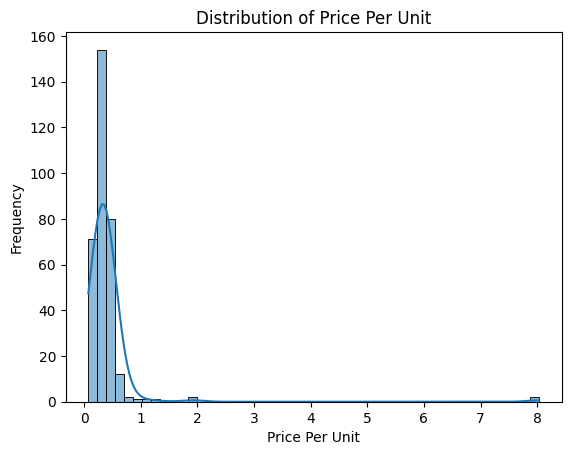

Fitting 5 folds for each of 42 candidates, totalling 210 fits

Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.1}
Best CV Score (MSE): 0.2808679120809006
Cross-Validation Results:
-0.2617119904585743 0.8295916387315367
Training Results:
-0.1379266326467656 0.888765367453566
Test Results
 0.10312020616082058 0.881099265398884
############################################################################################################################################################################################################################################################################################################


In [5]:
#want ti run a model on every category seperately

df_goruped=df.groupby("cleaned_category")

for name, group in df_goruped:
    print(f"Category: {name}, Number of items: {len(group)}") 
    print("Modelling for ",{name})
    model_df=group
    model_df=pd.get_dummies(model_df, columns=['category','store','cleaned_category',"cleaned_unit"],prefix=['category','store',"cleaned_category","cleaned_unit"], drop_first=True)
    model_df.drop([
    "name"  ,     
    "product-link" ,    
    "image_url"  ,
    "cleaned_name"
    ], axis=1, inplace=True)
    model_df["cleaned_quantity"]=np.log1p(model_df["cleaned_quantity"])
    model_df["price_per_unit"]=np.log1p(model_df["price_per_unit"])
    model_df["cleaned_price"]=np.log1p(model_df["cleaned_price"])
    
    X= model_df.drop("cleaned_price", axis=1)
    y= model_df["cleaned_price"]

    sns.scatterplot(x=model_df["cleaned_quantity"], y=model_df["cleaned_price"])
    plt.xlabel("Cleaned Quantity (log scale)")
    plt.ylabel("Cleaned Price (log scale)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Scatter plot of Cleaned Quantity vs Cleaned Price (log-log scale)")
    plt.show()

    sns.scatterplot(x=model_df["price_per_unit"], y=model_df["cleaned_price"])
    plt.xlabel("Price Per Unit (log scale)")
    plt.ylabel("Cleaned Price (log scale)")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Scatter plot of Price Per Unit vs Cleaned Price (log-log scale)")
    plt.show()
    
    
    #histogram of cleaned_quantity
    sns.histplot(model_df['cleaned_quantity'], bins=50, kde=True)
    plt.title('Distribution of Cleaned Quantity')
    plt.xlabel('Cleaned Quantity')
    plt.ylabel('Frequency')
    plt.show()

    sns.histplot(model_df['cleaned_price'], bins=50, kde=True)
    plt.title('Distribution of Cleaned Price')
    plt.xlabel('Cleaned Price')
    plt.ylabel('Frequency')
    plt.show()

    sns.histplot(model_df['price_per_unit'], bins=50, kde=True)
    plt.title('Distribution of Price Per Unit')
    plt.xlabel('Price Per Unit')
    plt.ylabel('Frequency')
    plt.show()
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )
    
    param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]  # Mix of L1 and L2
    }

    # Initialize Elastic Net
    elastic_net = ElasticNet(max_iter=10000, random_state=42)

    # GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=elastic_net,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )

    # Fit on training data
    grid_search.fit(X_train, y_train)

    # Best parameters
    print("\nBest Parameters:", grid_search.best_params_)
    print("Best CV Score (MSE):", -grid_search.best_score_)
    
    model = ElasticNet(alpha=grid_search.best_params_['alpha'], l1_ratio=grid_search.best_params_['l1_ratio'], max_iter=10000, random_state=42)

    cv_scores = cross_validate(
    model,
    X_train,
    y_train,
    cv=2,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True
    )
    
    print("Cross-Validation Results:")
    print(cv_scores['test_neg_mean_squared_error'].mean(), cv_scores['test_r2'].mean())
    print("Training Results:")
    print(cv_scores['train_neg_mean_squared_error'].mean(), cv_scores['train_r2'].mean())
    
    y_true=y_test
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    mse = mean_squared_error(y_true, y_pred)
    test_r2 = r2_score(y_true, y_pred)
    print("Test Results\n", mse, test_r2)
    
    print("#"*300)
    
    predicted_prices=model.predict(X)
    predicted_prices=np.expm1(predicted_prices)
    predicted_prices=pd.DataFrame(predicted_prices, columns=["predicted_cleaned_price"],index=X.index)
    predicted_df=pd.concat([group, predicted_prices], axis=1)
    predicted_df.to_csv("predicted_prices.csv",
    mode='a',      # Crucial: 'a' for append
    header=False,  # Crucial: Do not write the header again
    index=False    # Standard practice: Do not write the DataFrame index
    )
    